# Problem Set 4

In [1]:
import numpy as np
import scipy as sp
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import splu
from scipy.sparse.linalg import spsolve
from scipy.io import loadmat
import matplotlib.tri as tri
import matplotlib.pyplot as plt
import time
import pandas as pd
from IPython.display import display, Latex
import math
import time
# chargement des classes (modifiées pour le problème 4)
from reduce_basis_time import *

/home/flecourtier/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Le problème qui nous intéresse est l'ailette thermique des problèmes précédents, mais nous considérons maintenant le cas dépendant du temps. Nous supposons que la température de l'ailette est initialisée à zéro (non dimensionnée) et qu'un flux de chaleur est ensuite appliqué à la racine. La sortie d'intérêt est la température moyenne de l'ailette. Dans ce but, nous divisons l'intervalle de temps $I=]0,t_f]$ en $K$ sous-intervalles de longueur égale $\Delta=\frac{t_f}{K}$, et définissons $t^k=k\Delta_t, \; 0\le k\le K$. Nous considérerons Euler implicit pour l'intégration temporelle. Nous appelerons encore le (vrai) espace d'approximation par éléments finis $X\in X_e$.

L'énoncé de notre problème est alors : Etant donné un paramètre $\mu\in D$, nous évaluons la sortie
$$s^k(\mu)=l(u^k(\mu)), \quad 1\le k\le K$$
où la variable $u^k(\mu), \quad 1\le k\le K$ satifait
$\begin{equation}
m\left(\frac{u^k(\mu)-u^{k-1}(\mu)}{\Delta t},v\right)+a(u^k(\mu),v;\mu)=f(v)g(t^k),\forall v\in X
\end{equation}$
avec la condition initiale $u(t^0;\mu)=u_0=0$.

Ici la forme bilinéaire $a$ est défini comme dans le problème 1, la forme linéaire $f$ est donné par $f(v)=\int_{\Gamma_{root}}v$, la forme linéaire $l$ est définie par $l(v)=\int_\Omega v$, la forme bilinéaire $m$ est définie par
$$m(u,v)=\int_\Omega yv,\forall u,v\in X$$
et $g(t^k)$ désigne le contrôle d'entrée au moment $t = t^k$.

Nous considérons le cas particulier suivant : Nous supposons que les conductivités dans toutes les ailettes sont équivalentes et fixées à $k=k_i = 1, \quad i = 1,\dots,4$ et que le nombre de Biot $Bi$ peut varier entre 0.01 et 1. Nous avons donc $Bi\in D = [0.01,1]$. Nous considérons l'intervalle de temps $I = (0,10]$ avec un pas de temps discret $t = 0.1$ et donc $K = 100$.

Le fichier "FE_matrix_mass.mat" contient une structure, FE_matrix_mass, avec les matrices de masse pour les triangulations fines, moyennes et grossières utilisées précédemment. Pour générer le vecteur de sortie $L$, nous multiplierons la matrice de masse correspondante avec un vecteur contenant uniquement des 1. 

Nous utiliserons dans tout le problème la triangulation "medium" ainsi que $\bar{\mu}=0.1$

In [2]:
def construct_mu(Bi):
    k_i=1.
    assert(Bi >= 0.01 and Bi <= 1)
    return np.array([k_i, k_i, k_i, k_i, 1., Bi])
mu_prod = construct_mu(0.1)

type = 'medium'
tf=10
K=100
dt=tf/K

def compute_theta_q_mu(q,mu):
    assert(1<=q and q<=6)
    return mu[q-1]

def compute_alpha_LB(mu):
    tab_alpha_LB = np.zeros(6)
    for q in range(6):
        tab_alpha_LB[q] = compute_theta_q_mu(q+1,mu) / compute_theta_q_mu(q+1,mu_prod) 
    return np.min(tab_alpha_LB)

In [3]:
class offline_online_method_time():
    def __init__(self, modele):
        self.modele = modele
    
    def compute_norm_residual(self, U0, g, dt, tab_U_k_N, k, mu, quantity):
        tk = k*dt
        g_tk = g(tk,k)

        U_N_k = tab_U_k_N[k]
        U_N_km1 = tab_U_k_N[k-1]
        W_N_k = (U_N_k - U_N_km1)/dt

        val = g_tk**2 * quantity["CC"].copy() + 2 * g_tk * W_N_k.T @ quantity["DC"].copy() + W_N_k.T @ quantity["DD"].copy() @ W_N_k
        
        for q in range(6):
            theta_q_mu = compute_theta_q_mu(q+1,mu)

            val2 = 2 * g_tk * quantity["AqC"][q] + 2 * quantity["AqD"][q] @ W_N_k
            for q2 in range(6):
                theta_q2_mu = compute_theta_q_mu(q2+1,mu)
                val2 += theta_q2_mu * quantity["AqAqp"][q2][q] @ U_N_k

            val += theta_q_mu * U_N_k.T @ val2
        return np.sqrt(val)

    def compute_Delta_N_en(self, U0, g, dt, tab_U_k_N, k, mu, quantity):
        num = 0
        for kp in range(k):
            norm_residual = self.compute_norm_residual(U0, g, dt, tab_U_k_N, kp, mu, quantity)
            num += dt * norm_residual**2
        alpha_LB = compute_alpha_LB(mu)
        Delta_N_en_mu = np.sqrt(num/alpha_LB)
        return Delta_N_en_mu
    
    def offline_quantity(self):
        C = spsolve(self.modele.A_prod, self.modele.F_N_cal) # de taille N_cal
        D = spsolve(self.modele.A_prod, - self.modele.M_N_cal @ self.modele.Z)
        A_q = np.array([-spsolve(self.modele.A_prod, self.modele.A_N_cal_q[q] @ self.modele.Z) for q in range(6)]) # 6 matrices de taille N_cal*N

        CC = np.array(self.modele.prod_scalaire(C,C)) # scalaire
        DC = np.array(self.modele.prod_scalaire(D,C)) # vecteur de taille N
        DD = np.array(self.modele.prod_scalaire(D,D)) # matrice de taille N*N
        AqC = np.array([self.modele.prod_scalaire(A_q[q],C) for q in range(6)]) # Q=6 vecteurs de taille N
        AqD = np.array([self.modele.prod_scalaire(A_q[q],D) for q in range(6)]) # Q=6 matrices de taille N*N
        AqAqp = np.array([[self.modele.prod_scalaire(A_q[q2],A_q[q]) for q in range(6)] for q2 in range(6)]) # 6*6 matrices de taille N*N
        
        if(self.modele.Z.shape[1]==1):
            DC = DC[np.newaxis]
            DD = DD[np.newaxis,np.newaxis]
            AqC = AqC[:,np.newaxis]
            AqD = AqD[:,np.newaxis,np.newaxis]
            AqAqp = AqAqp[:,:,np.newaxis]
            
        return {"CC":CC,"DC":DC,"DD":DD,"AqC":AqC,"AqD":AqD,"AqAqp":AqAqp}

In [4]:
class direct_method_time():
    def __init__(self, modele):
        self.modele = modele
    
    def compute_R_mu(self, U0, g, dt, tab_U_k_N, k, mu):
        U_N_k = tab_U_k_N[k]
        W_N_k = (U_N_k-tab_U_k_N[k-1])/dt
        tk = k*dt
        R_mu = g(tk,k) * self.modele.F_N_cal - self.modele.M_N_cal @ self.modele.Z @ W_N_k - self.modele.get_A_N_cal(mu) @ self.modele.Z @ U_N_k
        return R_mu

    def compute_Delta_N_en(self, U0, g, dt, tab_U_k_N, k, mu):
        num = 0
        for kp in range(k):
            R_mu = self.compute_R_mu(U0, g, dt, tab_U_k_N, kp, mu)
            E_hat_mu = spsolve(self.modele.A_prod, R_mu)
            norm_residual = self.modele.norme(E_hat_mu)
            num += dt * norm_residual**2
        alpha_LB = compute_alpha_LB(mu)
        Delta_N_en_mu = np.sqrt(num/alpha_LB)
        return Delta_N_en_mu

## Part 1 - Reduced Basis Approximation

On cherche à implémenter une méthode offline-online pour l'approximation base réduite. 

L'équation (1) peut se réecrire sous forme matricielle :
$$\left(\frac{1}{\Delta t}M+A_\mu\right)U^k=Fg_k+\frac{1}{\Delta t}U^{k-1}$$
avec $U^0=0$ et
* $M$ : matrice de masse associée à $m$
* $A_\mu$ : matrice associée à $a(\cdot,\cdot;\mu)$
* $F$ : vecteur associé à $f$
* $U^k$ (resp. $U^{k-1}$) : vecteurs de composantes $u(t^k)$ (resp. $u(t^{k-1})$)
* $g_k=g(t^k)\in\mathbb{R}$

Nous générons d'abord une approximation de base réduite en choisissant une base que nous orthonormaliserons avec Gram-Schmidt. A cette fin, nous utilisons $g_k=\delta_{1k},1\le k\le 100$ et on fixe
$$X_N=span\{u^1(0.01),u^5(0.01),u^{10}(0.01),u^{20}(0.01),u^{30}(0.01),u^5(0.1),u^{10}(0.1),u^{20}(0.1),u^5(1),u^{10}(1)\}$$

On va l'équation matricielle ci-dessus où les composantes sont ici associées à l'espace des éléments finis, on a :
$$\left(\frac{1}{\Delta t}M_{\mathcal{N}}+A_\mu^{\mathcal{N}}\right)U_{\mathcal{N}}^k=F^{\mathcal{N}}g_k+\frac{1}{\Delta t}U_{\mathcal{N}}^{k-1}$$
avec $M_{\mathcal{N}}\in \mathbb{R}^{\mathcal{N}\times\mathcal{N}}$, $A^\mathcal{N}_\mu\in \mathbb{R}^{\mathcal{N}\times\mathcal{N}}$, $F^\mathcal{N}\in \mathbb{R}^{\mathcal{N}}$ et $U_\mathcal{N}^k\in \mathbb{R}^{\mathcal{N}}$ (resp. $U_\mathcal{N}^{k-1}$)

Pour déterminer les vecteurs $u^k(\mu)$ qui engendre $X_N$, il suffit alors de résoudre itérativement le système matricielle ci-dessus jusqu'à $k$ en utilisant la décomposition LU de $\left(\frac{1}{\Delta t}M_{\mathcal{N}}+A_\mu^{\mathcal{N}}\right)$.



Pour déterminer la solution dans l'espace base réduite en $\mu$ au temps $k$ de notre système $u_N^{k}(\mu)$, on résout le système matricielle :
$$\left(\frac{1}{\Delta t}M_{N}+A_\mu^{N}\right)U_{N}^k=F^{N}g_k+\frac{1}{\Delta t}U_{N}^{k-1}$$
avec $M_{N}=Z^T M_{\mathcal{N}}Z\in \mathbb{R}^{N\times N}$, $A^N_\mu=Z^T A^{\mathcal{N}}_\mu Z\in \mathbb{R}^{N\times N}$, $F^N=Z^T F^{\mathcal{N}}\in \mathbb{R}^{N}$ et $U_N^k\in \mathbb{R}^{N}$ (resp. $U_N^{k-1}$) 

Comme $A_\mu^{N}=\sum_{q=1}^{Q}\theta_q(\mu)Z^T A^q Z$, on calculera offline les quantités $Z^T M_{\mathcal{N}}Z$ et $Z^T A^q Z$ et comme pour la solution en élément fini, il suffit alors de résoudre itérativement le système matricielle ci-dessus jusqu'à $k$ en utilisant la décomposition LU de $\left(\frac{1}{\Delta t}M_{N}+A_\mu^{N}\right)$.

In [5]:
# génération de X_N
modele = finite_element_time(type)
U0 = np.zeros(modele.N_cal)
def g(tk,k):
    return (int)(k==1)

dict_basis = {"val1": (0.01,[1,5,10,20,30]), "val2": (0.1,[5,10,20]), "val3": (1.,[5,10])}
X_N = []
for key,value in dict_basis.items():
    Bi = value[0]
    mu = construct_mu(Bi)

    list_k = value[1]
    nv_K = np.max(list_k)
    tab_Uk = modele.get_u_N_cal_k(U0,g,dt,nv_K,mu)
    for Uk in tab_Uk[list_k]:
        X_N.append(Uk)
X_N = np.array(X_N).T

On va plot les sorties $s^k(\mu),s_N^k(\mu)$ et l'erreur $|s^k(\mu)-s_N^k(\mu)|$ par rapport au temps en utilisant $g(t^k)=1-cos(t^k)$ et $\mu=0.05$.

In [6]:
sample = 5 # given X_N
ortho = True #to orthonormalize when init
modele=reduce_basis_time(type,sample,mu_prod,ortho=ortho,X_N=X_N)

def g(tk,k):
    return 1-np.cos(tk)

mu = construct_mu(0.05)
U0 = np.zeros(modele.N_cal)
s_k_N_cal,tab_U_k_N_cal = modele.get_T_root_N_cal_k(U0,g,dt,K,mu)
U0 = np.zeros(modele.N)
s_k_N,tab_U_k_N = modele.get_T_root_N_k(U0,g,dt,K,mu)

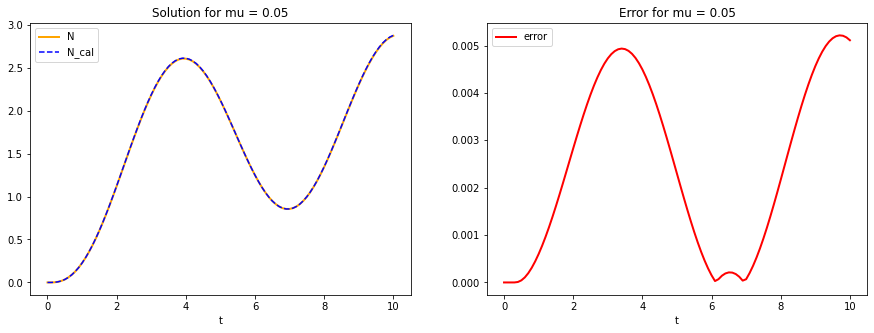

In [7]:
tab_tk = np.linspace(0,tf,K+1)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(tab_tk,s_k_N,'orange',label='N',linewidth=2)
axs[0].plot(tab_tk,s_k_N_cal,'b--',label='N_cal',linewidth=1.5)
axs[0].set_title('Solution for mu = '+str(mu[-1]))
axs[0].set_xlabel('t')
axs[0].legend()

axs[1].plot(tab_tk,np.abs(s_k_N-s_k_N_cal),'r',label='error',linewidth=2)
axs[1].set_title('Error for mu = '+str(mu[-1]))
axs[1].set_xlabel('t')
axs[1].legend()

On va plot $|||u^k(\mu)|||,|||u_N^k(\mu)|||$ et l'erreur $|||u^k(\mu)-u_N^k(\mu)|||$ par rapport au temps en utilisant $g(t^k)=1-cos(t^k)$ et $\mu=0.05$.

In [8]:
A_N_cal_mu = modele.get_A_N_cal(mu)
def norm_mu(x,A_N_cal_mu):
    return np.sqrt(x.T@A_N_cal_mu@x)

norm_u_k_N_cal = [norm_mu(u_k_N_cal,A_N_cal_mu) for u_k_N_cal in tab_U_k_N_cal]
norm_u_k_N = [norm_mu(modele.Z_complet@u_k_N,A_N_cal_mu) for u_k_N in tab_U_k_N]
norm_error = [norm_mu(u_k_N_cal-modele.Z_complet@u_k_N,A_N_cal_mu) for u_k_N,u_k_N_cal in zip(tab_U_k_N,tab_U_k_N_cal)]

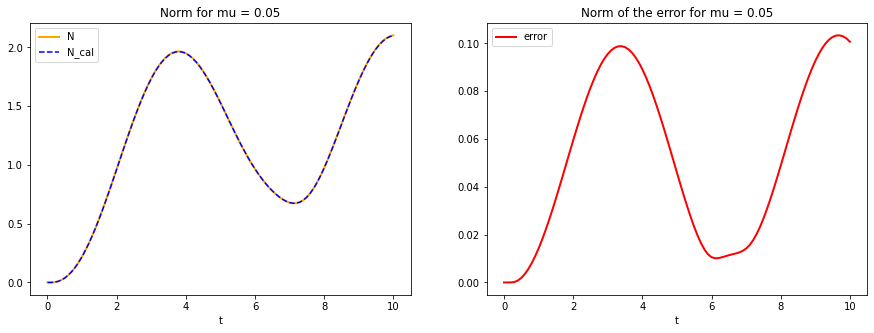

In [9]:
tab_tk = np.linspace(0,tf,K+1)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(tab_tk,norm_u_k_N_cal,'orange',label='N',linewidth=2)
axs[0].plot(tab_tk,norm_u_k_N,'b--',label='N_cal',linewidth=1.5)
axs[0].set_title('Norm for mu = '+str(mu[-1]))
axs[0].set_xlabel('t')
axs[0].legend()

axs[1].plot(tab_tk,norm_error,'r',label='error',linewidth=2)
axs[1].set_title('Norm of the error for mu = '+str(mu[-1]))
axs[1].set_xlabel('t')
axs[1].legend()

## Part 2 - A Posterior Error Estimation

On cherche à calculer la norme d'énergie 
$$\Delta^k_N(\mu)=\sqrt{\frac{\sum_{k'=1}^{k}\Delta t||\hat{e}^{k'}(\mu)||_X^2}{\alpha_{LB}(\mu)}}$$
avec 
$$||\hat{e}^k(\mu)||_X=||r^k(\cdot;\mu)||_{X'}, \qquad \alpha_{LB}(\mu)=\min_q\frac{\theta_q(\mu)}{\theta_q(\bar{\bar{\mu}})}\alpha(\bar{\bar{\mu}})$$
Par le théorème de représentation de Riesz, on sait qu' $\exists ! \hat{e}^k\in X, \forall v\in X$
$$(\hat{e}^k(\mu),v)_X=r^k(v;\mu)$$
et le résidu est donné par
$$r^k(v;\mu)=f(v;\mu)g(t^k)-m\left(\frac{u^k(\mu)-u^{k-1}(\mu)}{\Delta t},v\right)-a(u_N^k(\mu),v,\mu)$$

On va implémenter le calcul de la norme d'énergie par méthode directe et par une méthode offline-online. 

On effectuera une comparaison des 2 méthodes pour 10 valeurs aléatoires dans $D$ et à différents temps.

In [10]:
def g(tk,k):
    return 1-np.cos(tk)

mu = construct_mu(0.05)
k = 30

# N = 3
U0 = np.zeros(modele.N)
tab_U_k_N = modele.get_u_N_k(U0, g, dt, K, mu)

### Méthode direct

Le problème consiste à trouver $\hat{E}^k\in\mathbb{R}^\mathcal{N}$ tel que
$$A_\mathcal{N}(\bar{\mu})\hat{E}^k=F^\mathcal{N}*g_k-M^\mathcal{N}Z\frac{U_N^k-U_N^{k-1}}{\Delta t}-A_\mathcal{N}(\mu)ZU_N$$
Et ainsi
$$||r(u_N(\mu),v;\mu)||_{X'}=||\hat{e}(\mu)||_X=\sqrt{(\hat{e}(\mu),\hat{e}(\mu))_X}=\sqrt{(A_\mathcal{N}(\bar{\mu})^{-1}R_\mu,A_\mathcal{N}(\bar{\mu})^{-1}R_\mu)_X}$$
avec
$$R_\mu = F^\mathcal{N}*g_k-M^\mathcal{N}Z\frac{U_N^k-U_N^{k-1}}{\Delta t}-A_\mathcal{N}(\mu)ZU_N^k$$

#### Méthode offline-online

Le problème consiste toujours à trouver $\hat{E}^k\in\mathbb{R}^\mathcal{N}$ tel que
$$A_\mathcal{N}(\bar{\mu})\hat{E}^k=F^\mathcal{N}*g_k-M^\mathcal{N}Z\frac{U_N^k-U_N^{k-1}}{\Delta t}-A_\mathcal{N}(\mu)ZU_N$$
Dans la suite nous noterons $\mathbb{X}^\mathcal{N}:=A_\mathcal{N}(\bar{\mu})$ la matrice associé au produit scalaire $(\cdot,\cdot)_X$. Donc le problème se réecrit :
$$\mathbb{X}^\mathcal{N}\hat{E}^k=F^\mathcal{N}*g_k-M^\mathcal{N}Z\frac{U_N^k-U_N^{k-1}}{\Delta t}-A_\mathcal{N}(\mu)ZU_N$$
On utilise maintenant la décomposition affine :
$$A_\mathcal{N}(\mu)=\sum_{q=1}^{Q}\theta_q(\mu) A_\mathcal{N}^q$$
Donc
$$\mathbb{X}^\mathcal{N}\hat{E}^k=F^\mathcal{N}*g_k-M^\mathcal{N}Z\frac{U_N^k-U_N^{k-1}}{\Delta t}-\sum_{q=1}^{Q}\theta_q(\mu) A_\mathcal{N}^qZU_N$$

Ainsi en offline, on peut effectuer les étapes suivantes :

* Trouver $C\in\mathbb{R}^\mathcal{N}$ tel que
    $$\mathbb{X}^\mathcal{N}C = F^\mathcal{N}$$
* Trouver $D\in\mathbb{R}^{\mathcal{N}\times N}$ tel que
    $$\mathbb{X}^\mathcal{N}D = -M^\mathcal{N}Z$$
* Trouver $A_q\in\mathbb{R}^{\mathcal{N}\times N}$ ($1\le q\le Q$) tel que
    $$\mathbb{X}^\mathcal{N}A_q = -A_\mathcal{N}^qZ$$

Et le problème se réecrit alors

$$\hat{E}^k=g_kC-DW_N^k-\sum_{q=1}^{Q}\theta_q(\mu) A_qU_N$$

avec

$$W_N^k:=\frac{U_N^k-U_N^{k-1}}{\Delta t}$$

On a alors

$$\begin{aligned}
    ||\hat{E}^k||_X^2&=\left|\left|g_kC+DW_N^k+\sum_{q=1}^{Q}\theta_q(\mu) A_qU_N\right|\right|_X^2 \\
    &=\left(g_kC+DW_N^k+\sum_{q=1}^{Q}\theta_q(\mu) A_qU_N,g_kC+DW_N^k+\sum_{q'=1}^{Q}\theta_{q'}(\mu) A_{q'}U_N\right)_X \\
    &=g_k^2(C,C)_X+2g_k(C,DW_N^k)_X+2g_k(C,\sum_{q=1}^{Q}\theta_q(\mu) A_qU_N)_X + (DW_N^k,DW_N^k)_X\\
        & \qquad + 2(DW_N^k,\sum_{q=1}^{Q}\theta_q(\mu)A_qU_N)_X+(\sum_{q=1}^{Q}\theta_q(\mu) A_qU_N,\sum_{q'=1}^{Q}\theta_{q'}(\mu) A_{q'}U_N)_X \\
    &=g_k^2(C,C)_X+2g_k(DW_N^k,C)_X+2g_k\sum_{q=1}^{Q}\theta_q(\mu)(A_qU_N,C)_X + (DW_N^k,DW_N^k)_X \\
        & \qquad + 2\sum_{q=1}^{Q}\theta_q(\mu)(A_qU_N,DW_N^k)_X+\sum_{q=1}^{Q}\sum_{q'=1}^{Q}\theta_q(\mu)\theta_{q'}(\mu)(A_qU_N,A_{q'}U_N)_X \\
    &=g_k^2(C,C)_X+2g_k(DW_N^k,C)_X+(DW_N^k,DW_N^k)_X \\
        & \qquad + \sum_{q=1}^{Q}\theta_q(\mu)\left[2g_k(A_qU_N,C)_X +2(A_qU_N,DW_N^k)_X+\sum_{q'=1}^{Q}\theta_{q'}(\mu)(A_qU_N,A_{q'}U_N)_X\right] \\
    &=g_k^2C^T\mathbb{X}^\mathcal{N}C+2g_k(DW_N^k)^T\mathbb{X}^\mathcal{N}C+(DW_N^k)^T\mathbb{X}^\mathcal{N}(DW_N^k) \\
        & \qquad + \sum_{q=1}^{Q}\theta_q(\mu)\left[2g_k(A_qU_N)^T\mathbb{X}^\mathcal{N}C +2(A_qU_N)^T\mathbb{X}^\mathcal{N}(DW_N^k)+\sum_{q'=1}^{Q}\theta_{q'}(\mu)(A_qU_N)^T\mathbb{X}^\mathcal{N}(A_{q'}U_N)\right] \\
    &=g_k^2\color{blue}C^T\mathbb{X}^\mathcal{N}C\color{black}+2g_k(W_N^k)^T\color{blue}D^T\mathbb{X}^\mathcal{N}C\color{black}+(W_N^k)^T\color{blue}D^T\mathbb{X}^\mathcal{N}D\color{black}W_N^k \\
        & \qquad + \sum_{q=1}^{Q}\theta_q(\mu)U_N^T\left[2g_k\color{blue}A_q^T\mathbb{X}^\mathcal{N}C\color{black} +2\color{blue}A_q^T\mathbb{X}^\mathcal{N}D\color{black}W_N^k+\sum_{q'=1}^{Q}\theta_{q'}(\mu)\color{blue}A_q^T\mathbb{X}^\mathcal{N}A_{q'}\color{black}U_N\right]
\end{aligned}$$

Et ainsi on peut calculer les quantitées suivantes offline :

$$\begin{align*}
&C^T\mathbb{X}^\mathcal{N}C\in\mathbb{R} \qquad &&A_q^T\mathbb{X}^\mathcal{N}C\in\mathbb{R}^N, \quad 1\le q\le Q \\
&D^T\mathbb{X}^\mathcal{N}C\in\mathbb{R}^N \qquad &&A_q^T\mathbb{X}^\mathcal{N}D\in\mathbb{R}^{N\times N}, \quad 1\le q\le Q \\
&D^T\mathbb{X}^\mathcal{N}D\in\mathbb{R}^{N\times N} \qquad &&A_q^T\mathbb{X}^\mathcal{N}A_{q'}\in\mathbb{R}^{N\times N}, \quad 1\le q,q'\le Q
\end{align*}$$

#### Comparaison des méthodes

In [11]:
D=[0.01,1]

direct = direct_method_time(modele)
offline_online = offline_online_method_time(modele)
quantity = offline_online.offline_quantity()

tab_Bi=np.sort(np.random.uniform(low=D[0], high=D[1], size=(10,)))
tab_k = np.arange(0,K+1,20)
print("k in ",tab_k)

res_direct = np.zeros((10,len(tab_k)))
res_off_on = np.zeros((10,len(tab_k)))

for (i,Bi) in enumerate(tab_Bi):
    print("Bi=",Bi)
    mu = construct_mu(Bi)
    tab_U_k_N = modele.get_u_N_k(U0, g, dt, K, mu)
    for (j,k) in enumerate(tab_k):
        res_direct[i,j] = direct.compute_Delta_N_en(U0, g, dt, tab_U_k_N, k, mu)
        res_off_on[i,j] = offline_online.compute_Delta_N_en(U0, g, dt, tab_U_k_N, k, mu, quantity)

k in  [  0  20  40  60  80 100]
Bi= 0.176180001963859
Bi= 0.3169443399084486
Bi= 0.34156013923094464
Bi= 0.346508137418192
Bi= 0.6179387157005924
Bi= 0.6351157598062264
Bi= 0.6495009353520704
Bi= 0.8300215345866243
Bi= 0.8422392627066034
Bi= 0.856769729525991


In [12]:
df_direct = pd.DataFrame(data=res_direct,index=tab_Bi,columns=tab_k)
df_direct.columns = ["k = " + str(k) for k in tab_k]
df_direct.index = ["Bi = " + str(np.round(Bi,4)) for Bi in tab_Bi]
# df_direct = df_direct.transpose()

df_offline_online = pd.DataFrame(data=res_off_on,index=tab_Bi,columns=tab_k)
df_offline_online.columns = ["k = " + str(k) for k in tab_k]
df_offline_online.index = ["Bi = " + str(np.round(Bi,4)) for Bi in tab_Bi]
# df_offline_online = df_offline_online.transpose()
       
print("Comparaison des deux méthodes :")
# argument result_names disponible à partir de pandas 1.5.2
df_direct.compare(df_offline_online,result_names=('direct', 'off/on'))

Comparaison des deux méthodes :


k = 20              k = 40              k = 60            \
               direct    off/on    direct    off/on    direct    off/on   
Bi = 0.1762  6.856695  6.856695  6.858583  6.858583  6.860606  6.860606   
Bi = 0.3169  5.369665  5.369665  5.372111  5.372111  5.374757  5.374757   
Bi = 0.3416  5.191413  5.191413  5.193950  5.193950  5.196696  5.196696   
Bi = 0.3465  5.157378  5.157378  5.159934  5.159934  5.162699  5.162699   
Bi = 0.6179  3.860816  3.860816  3.864354  3.864354  3.868115  3.868115   
Bi = 0.6351  3.803577  3.803577  3.807178  3.807178  3.810998  3.810998   
Bi = 0.6495  3.757164  3.757164  3.760819  3.760819  3.764688  3.764688   
Bi = 0.83    3.270959  3.270959  3.275320  3.275320  3.279796  3.279796   
Bi = 0.8422  3.243355  3.243355  3.247767  3.247767  3.252284  3.252284   
Bi = 0.8568  3.211249  3.211249  3.215723  3.215723  3.220288  3.220288   

               k = 80             k = 100            
               direct    off/on    direct    off/on  
Bi = 0.1762  6.861672  6.861672  6.863622  6.863622  
Bi = 0.3169  5.376122  5.376122  5.378680  5.378680  
Bi = 0.3416  5.198108  5.198108  5.200762  5.200762  
Bi = 0.3465  5.164121  5.164121  5.166794  5.166794  
Bi = 0.6179  3.870005  3.870005  3.873686  3.873686  
Bi = 0.6351  3.812916  3.812916  3.816661  3.816661  
Bi = 0.6495  3.766629  3.766629  3.770428  3.770428  
Bi = 0.83    3.282026  3.282026  3.286532  3.286532  
Bi = 0.8422  3.254533  3.254533  3.259090  3.259090  
Bi = 0.8568  3.222560  3.222560  3.227178  3.227178

## Part 3 - Sampling Procedure (non aboutit)

On cherche à implémenter l'algorithme POD-Greedy :

In [13]:
# to convert the algorithm from md to pdf
# !pandoc greedy_algorithm.md -o greedy_algorithm.pdf

<img src="pod_greedy_algorithm.png" width="500"/>

où
$$e_{N,proj}^k(\mu^*)=u^k(\mu)-Z_N(Z_N^T\mathbb{X}^\mathcal{N}u^k(\mu))$$
et $POD_X(\{e_{N,proj}^k(\mu), 1\le k\le K\},1):=\psi^{POD,1}$ est calculée avec les étapes suivantes :
1. Calculer la matrice de corrélation $C^{POD}\in\mathbb{R}^{K\times K}$ : 
    $$C^{POD}_{i,j}=\frac{1}{K}(e_{N,proj}^i(\mu^*),e_{N,proj}^j(\mu^*))$$
2. Résoudre pour le couple $(\psi^{POD,max},\lambda^{POD,max})$ la plus grande valeur propre $\lambda^{POD,max}$ pour
    $$C^{POD}\psi^{POD,max}=\lambda^{POD,max}\psi^{POD,max}$$
3. Calculer le plus grand mode POD
    $$\psi^{POD,1}=\sum_{k=1}^K \psi_k^{POD,max}u^k(\mu)$$

*Cette implémentation n'est pas fonctionnelle !*

In [14]:
def greedy_algorithm(method,mu_1,mu_train,g,dt,K,eps_tol):
    Delta_N_max = 1
    tab_mu_N = []
    mu_N = mu_1
    while Delta_N_max >= eps_tol:
        print("N = ",method.modele.N," ; Delta_N_max = ",Delta_N_max)
        Delta_N_max,mu_N = method.modele.one_step_greedy(method,mu_train,g,dt,K,mu_N)
        tab_mu_N.append((mu_N,Delta_N_max))
    tab_mu_N.append(None)

    return tab_mu_N

In [15]:
type='medium'
xi_train = np.logspace(np.log10(D[0]),np.log10(D[1]),100)
mu_train = np.array([construct_mu(Bi) for Bi in xi_train])
mu_1 = construct_mu(D[0])
S_1 = np.array([mu_1])
sample=0
eps_tol=1e-6
def g(tk,k):
    return (int)(k==1)

modele=reduce_basis_time(type,sample,mu_prod,S_N=S_1)
method=offline_online_method_time(modele)

In [16]:
tab_mu_N = greedy_algorithm(method,mu_1,mu_train,g,dt,K,eps_tol)

N =  0  ; Delta_N_max =  1


/mnt/c/Users/lecou/OneDrive - etu.unistra.fr/Master/M2/S1/calcul_scientifique_3/Prudhomm/Projet/2022-sc3-problem-4-flecourtier/reduce_basis_time.py:212: ComplexWarning: Casting complex values to real discards the imaginary part
  self.Z_complet[:,0] = psi_POD1
/mnt/c/Users/lecou/OneDrive - etu.unistra.fr/Master/M2/S1/calcul_scientifique_3/Prudhomm/Projet/2022-sc3-problem-4-flecourtier/reduce_basis_time.py:142: LinAlgWarning: Diagonal number 1 is exactly zero. Singular matrix.
  lu, piv = lu_factor(B)


ValueError: array must not contain infs or NaNs